In [1]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--dataset_name', type=str, default='COVID19_ChestXray') # required
parser.add_argument('--model_name', type=str, default='resnet50') #required
parser.add_argument('--result_path', type=str, default='result', help='output path')
parser.add_argument('--data_path', type=str, default='dataset_partition', help='path for data partition')

# Training
parser.add_argument('--num_epochs', type=int, default=8)
parser.add_argument('--batch_size', type=int, default=16)
parser.add_argument('--lr', type=float, default=1e-5)
parser.add_argument('-e', '--lr_decay', type=float, default=0.995,
                    help='Learning rate decay, applied every step of the optimization')
parser.add_argument('--seed', type=int, default=1,
                    help='Random seed to use')
parser.add_argument('--log_step', type=int, default=50, help='step size for prining log info')
parser.add_argument('--save_step', type=int, default=50, help='step size for saving trained models')

parser.add_argument('--flag_retrain', default=False, action='store_true', help='Re train')
parser.add_argument('--flag_reg', default=False, action='store_true', help='Regularizer')
parser.add_argument('--flag_plot', default=False, action='store_true', help='Plot')
parser.add_argument('--img_size', type=int, default=256)

# Model parameters
args = parser.parse_args("")

In [2]:
import os, sys, time, shutil
import numpy as np
import importlib
import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, utils
import torchvision
import pdb

device=torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Arguments
model_name=args.model_name + '-' + args.dataset_name
dataset_path=os.path.join(args.data_path, args.dataset_name)
output_path=os.path.join(args.result_path, model_name)

# saved checkpoint
model_path=os.path.join(output_path, 'snapshots')
net_path=os.path.join(model_path, 'net.pth')
adv_path = os.path.join(model_path, 'adv.pth')
sample_path=os.path.join(output_path, 'samples')
log_path=os.path.join(output_path, "log.txt")
run_path = os.path.join(output_path, 'runs')

params_str = 'debug'
writer_path=os.path.join(run_path, params_str) 

# makedir
def make_dir(dirname, rm=False):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    elif rm:
        print('rm and mkdir ', dirname)
        shutil.rmtree(dirname)
        os.makedirs(dirname)

make_dir(args.result_path)
make_dir(output_path)
make_dir(model_path)
make_dir(sample_path)
make_dir(run_path)
logf=open(log_path, 'w')
make_dir(writer_path, rm=True)
writer=SummaryWriter(comment=model_name, log_dir=writer_path)

rm and mkdir  result/resnet50-COVID19_ChestXray/runs/debug


In [3]:
import datasets
importlib.reload(datasets)

/home/akshay/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


<module 'datasets' from '/home/akshay/Desktop/covid/datasets.py'>

In [4]:
torch.cuda.empty_cache() 

In [5]:
# Logging helper functions 
def log_loss(epoch, step, total_step, loss, start_time):
    # convert
    loss=loss.cpu().data.numpy()
    # msg
    message='Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, time: {:.4f}s'.format(
        epoch, args.num_epochs, step, total_step, loss, time.time() - start_time)
    # log out
    logf.write(message + '\n')
    print(message)
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
class SingleChannel(object):
    def __call__(self, img):
        img = img[0,:,:].unsqueeze(0)
        return img

train_transform = transforms.Compose([transforms.Resize(args.img_size + 24), 
                                      transforms.RandomRotation(10),
                                      transforms.CenterCrop(args.img_size),
                                      transforms.ToTensor(),
                                      SingleChannel()])
test_transform = transforms.Compose([transforms.Resize(args.img_size + 24), 
                                     transforms.CenterCrop(args.img_size),
                                     transforms.ToTensor(),
                                     SingleChannel()])
trainset = datasets.COVID19_ChestXray_Merged_Dataset(dataset_partition=args.data_path, train=True, 
                                                    transform=train_transform)
testset = datasets.COVID19_ChestXray_Merged_Dataset(dataset_partition=args.data_path, train=False, 
                                                    transform=test_transform)
trainloader = DataLoader(trainset, batch_size=args.batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=args.batch_size, shuffle=True)

torch.Size([1, 256, 256]) tensor(1.)


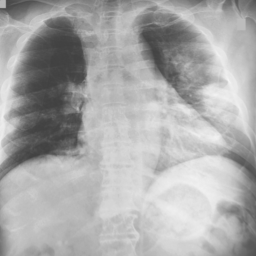

torch.Size([1, 256, 256]) tensor(1.)


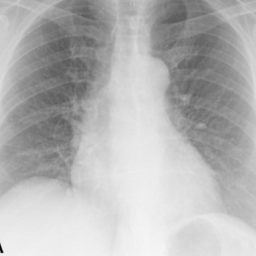

torch.Size([1, 256, 256]) tensor(1.)


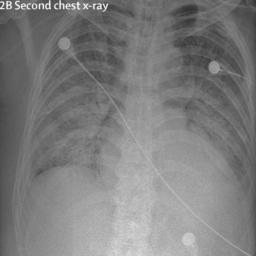

torch.Size([1, 256, 256]) tensor(1.)


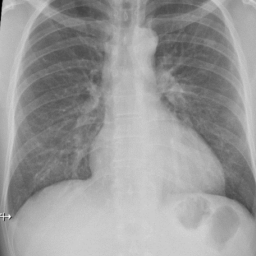

torch.Size([1, 256, 256]) tensor(1.)


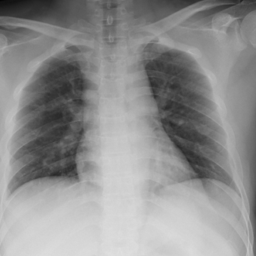

In [7]:
for i in range(5):
    img, label = testset.__getitem__(i)
    print(img.shape, label)
    display(transforms.ToPILImage()(img))

In [8]:
import model as mymodel
importlib.reload(mymodel)

<module 'model' from '/home/akshay/Desktop/covid/model.py'>

In [9]:
def initialize_using_pretrained(resnet):
    pretrained_resnet = torchvision.models.resnet50(pretrained=True)
    resnet.layer1.load_state_dict(pretrained_resnet.layer1.state_dict())
    resnet.layer2.load_state_dict(pretrained_resnet.layer2.state_dict())
    resnet.layer3.load_state_dict(pretrained_resnet.layer3.state_dict())
    resnet.layer4.load_state_dict(pretrained_resnet.layer4.state_dict())

In [10]:
resnet = mymodel.resnet50(num_classes=2)
initialize_using_pretrained(resnet)
resnet = resnet.to(device)

In [11]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=args.lr)
lmbda = lambda epoch: 1.0
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=[lmbda])

In [12]:
def train_epoch(epoch, model, optimizer, dataloader, writer):
    model.train()
    start_time = time.time()
    loss_logger = AverageMeter()
    total_step = len(dataloader.dataset)//args.batch_size
    for idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        #pdb.set_trace()
        loss = F.cross_entropy(pred, labels.long())
        loss_logger.update(loss.item())
        
        if idx % args.log_step == 0:
            log_loss(epoch, idx, total_step, loss, start_time)
            start_time = time.time()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuracy = get_accuracy(model, dataloader)
    print('Train Acc:', accuracy)
    writer.add_scalar('Loss/train', loss_logger.avg, epoch)
    writer.add_scalar('Accuracy/train', accuracy, epoch)
    
def get_accuracy(model, dataloader):    
    model.eval()
    total = 0
    correct = 0
    
    i = 0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        #pdb.set_trace()
        pred_labels = torch.argmax(pred, 1)
        total += labels.size(0)
       
        correct += torch.sum(pred_labels == labels)
        
    return correct.cpu().numpy()/total

def test_epoch(epoch, model, dataloader, writer):
    model.eval()
    loss_logger = AverageMeter()
    
    pred_n = None
    correct_n = None
    i = 0
     
            
    
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        loss = F.cross_entropy(pred, labels.long())
        loss_logger.update(loss.item())
        pred_labels = torch.argmax(pred, 1)
        
        if i  == 0:
            i = i+1
            
            pred_n = pred_labels
            correct_n = labels
            
        else:
            pred_n = torch.cat((pred_n,pred_labels),0)
            correct_n = torch.cat((correct_n,labels),0)
            
        
    accuracy = get_accuracy(model, dataloader)
    print('Test Acc:', accuracy)
    writer.add_scalar('Loss/test', loss_logger.avg, epoch)
    writer.add_scalar('Accuracy/test', accuracy, epoch)
    
    confusion_vector = pred_n/correct_n
    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

#     print("CV", true_positives, false_positives, true_negatives, false_negatives)
    print("Precsion ", true_positives/(true_positives+false_positives),"Recall ", true_positives/(true_positives+false_negatives))
     
        
def train(model, optimizer, scheduler, trainloader, testloader, writer):
    for epoch in range(args.num_epochs):
        train_epoch(epoch, model, optimizer, trainloader, writer)
        test_epoch(epoch, model, testloader, writer)
        scheduler.step()
    print('Saving the model')
    torch.save(model.state_dict(), net_path)

In [13]:
#train(resnet, optimizer, scheduler, trainloader, testloader, writer)

Epoch [0/8], Step [0/50], Loss: 0.7245, time: 0.8508s
Epoch [0/8], Step [50/50], Loss: 0.2693, time: 26.2623s
Train Acc: 0.5
Test Acc: 0.5
Precsion  0.5 Recall  1.0
Epoch [1/8], Step [0/50], Loss: 0.1837, time: 0.5749s
Epoch [1/8], Step [50/50], Loss: 0.0826, time: 25.4063s
Train Acc: 0.9900744416873449
Test Acc: 0.9603960396039604
Precsion  0.926605504587156 Recall  1.0
Epoch [2/8], Step [0/50], Loss: 0.0542, time: 0.3239s
Epoch [2/8], Step [50/50], Loss: 0.0144, time: 25.8406s
Train Acc: 0.9987593052109182
Test Acc: 0.9405940594059405
Precsion  0.8938053097345132 Recall  1.0
Epoch [3/8], Step [0/50], Loss: 0.0163, time: 0.4349s
Epoch [3/8], Step [50/50], Loss: 0.0700, time: 26.1461s
Train Acc: 0.9987593052109182
Test Acc: 0.9455445544554455
Precsion  0.9017857142857143 Recall  1.0
Epoch [4/8], Step [0/50], Loss: 0.0104, time: 0.4368s
Epoch [4/8], Step [50/50], Loss: 0.0046, time: 25.8433s
Train Acc: 0.9987593052109182
Test Acc: 0.9603960396039604
Precsion  0.926605504587156 Recall  1

## Insights
We can visualize on what the model focusses on from this data using CAM.

In [13]:
import cv2
from matplotlib import rcParams
rcParams['figure.figsize'] = 16,16
import matplotlib.cm as cm
import cam
importlib.reload(cam)
from gradcam.grad_cam import (
    BackPropagation,
    Deconvnet,
    GradCAM,
    GuidedBackPropagation,
    occlusion_sensitivity,
)

In [14]:
# Reload the model from the saved snapshot
model = mymodel.resnet50(num_classes=2).to(device)
model.load_state_dict(torch.load(net_path))

<All keys matched successfully>

### Grad-CAM
Based on https://github.com/kazuto1011/grad-cam-pytorch#demo-1

In [15]:
def get_act_map(gradient):
    gradient = gradient.cpu()
    gradient -= gradient.min()
    gradient /= gradient.max()
    return gradient

In [16]:
def generate_guided_gradcam(model, dataloader):
    rcParams['figure.figsize'] = 16,16
    def show_cams(image, regions, gradients):
        image = image.cpu()
        act_map = get_act_map(torch.mul(regions, gradients))
        gcam_map = cam.apply_colormap_on_image(to_image(image), np.uint8(regions.squeeze().cpu().numpy()*255))
        fig, ax = plt.subplots(1,3)
        ax[0].imshow(to_image(image), cmap='gray')
        ax[2].imshow(to_image(act_map), cmap='gray')
        ax[1].imshow(gcam_map)
        plt.show()
    
    model.eval()
    to_image = transforms.ToPILImage()
    
    for images, labels in dataloader:
        images = images.to(device)
        pred = model(images)
        pred_labels = torch.argmax(pred, 1)
        
        # For each covid-19 positive chest-xray we try to see the regions used according to gradcam
        gcam = GradCAM(model=model)
        _ = gcam.forward(images)
        gbp = GuidedBackPropagation(model=model)
        _ = gbp.forward(images)
        ids = torch.argmax(pred, 1).unsqueeze(1)
        # Gradient
        gbp.backward(ids=ids)
        gradients = gbp.generate()

        # Grad-CAM
        gcam.backward(ids=ids)
        regions = gcam.generate(target_layer="layer4")  # For resent the target layer is layer4
        
        
        # Show the activation maps
        for i in range(len(images)):
            if labels[i] == 1 and pred_labels[i] == 1:
                print('COVID-19')
                
            elif labels[i] == 0 and pred_labels[i] == 0:
                print('Normal')
                
            else:
                continue
            
            show_cams(images[i], regions[i], gradients[i])
        break

Normal


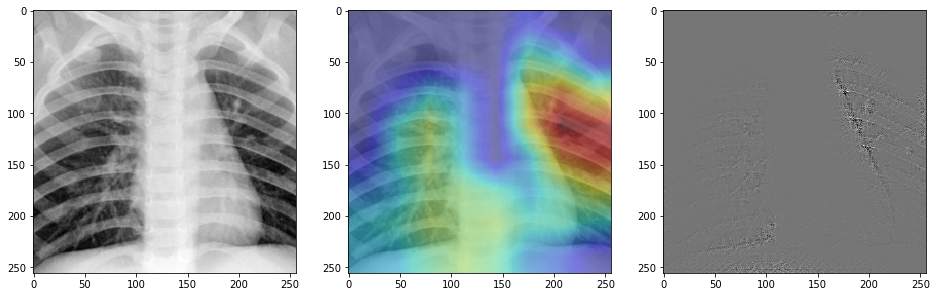

COVID-19


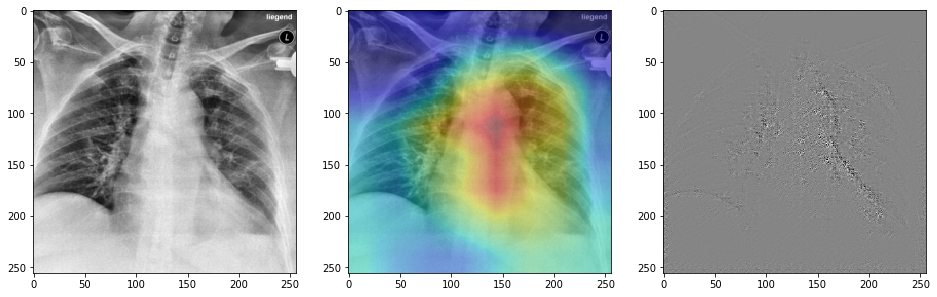

COVID-19


In [ ]:
generate_guided_gradcam(model, testloader)

### CAM

In [19]:
to_image = transforms.ToPILImage()
rcParams['figure.figsize'] = 10,10
for i in range(len(testset)):
    img, label = testset.__getitem__(i)
    if label == 1:
        print('COVID-19')
    else:
        continue
        print('Normal')
    cam_img = cam.get_cam_images(model, 'layer4', img.to(device).unsqueeze(0), corona_idx=label)[0]
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(to_image(img), cmap='gray')
    ax[1].imshow(cam_img)
    plt.show()

COVID-19


IndexError: tensors used as indices must be long, byte or bool tensors